In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
df = pd.read_csv("datasets/customer_dataframe.csv", sep="\t", index_col=0)
df.head()

,TProd,DProd,MaxPO,MinPO,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder
CustomerID,,,,,,,,,,,,,,
17850,1702,21,141,12,48.629,5317.89,6.36,107.25,151.940,31,3.960,34,4.137,3.186
13047,1355,105,309,3,84.688,3089.10,6.64,68.00,193.069,35,3.926,9,5.421,3.875
12583,4978,114,714,100,292.824,6629.34,6.80,132.80,389.961,50,2.140,15,5.804,4.087
13748,439,24,208,8,87.800,948.25,9.36,204.00,189.650,0,3.996,5,4.080,2.322
15100,58,1,32,16,9.667,635.10,175.20,350.40,105.850,22,10.950,3,2.252,2.252


In [3]:
df_aux = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [4]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_aux.values)
X

array([[0.00865911, 0.00621536, 0.01533992, 0.00883257],
       [0.00689371, 0.01082413, 0.01949232, 0.00875433],
       [0.02532612, 0.03742638, 0.03937061, 0.00464412],
       ...,
       [0.00048841, 0.01226994, 0.03634574, 0.00834929],
       [0.00040192, 0.01009714, 0.02295738, 0.00874052],
       [0.00256924, 0.06454499, 0.08021807, 0.00451755]])

In [5]:
def get_dataframe(complete_df, flat_cluster):
    distinct_clusters = list(set(flat_cluster))
    sorted(distinct_clusters)
    cluster_index = {c:[] for c in distinct_clusters} 
    for i in range(len(flat_cluster)):
        cluster_index[flat_cluster[i]].append(i)
    clusters_df = {}
    indexes = df.index
    for c in distinct_clusters:
        elem = cluster_index[c]
        clusters_df[c] = df[df.index.isin([indexes[i] for i in elem])]
    return clusters_df

def plot_cluster_values(cdf, df_aux):
    attr = df_aux.columns
    clusters = [i for i in cdf]
    colors = ["red", "blue", "green", "yellow", "orange", "brown"]
    fig, axs = plt.subplots(len(attr),3,figsize=(15,15))
    for attr_index in range(len(attr)):
        mean_values = []
        max_values = []
        min_values = []
        for _, cluster_df in cdf.items():
            mean_values.append(cluster_df.describe()[attr[attr_index]][1])
            max_values.append(cluster_df.describe()[attr[attr_index]][7])
            min_values.append(cluster_df.describe()[attr[attr_index]][3])
        axs[attr_index][0].bar(clusters, mean_values, color=colors[:len(clusters)])
        axs[attr_index][0].set_title(f"{attr[attr_index]} - Mean")
        axs[attr_index][1].bar(clusters, max_values, color=colors[:len(clusters)])
        axs[attr_index][1].set_title(f"{attr[attr_index]} - Max")
        axs[attr_index][2].bar(clusters, min_values, color=colors[:len(clusters)])
        axs[attr_index][2].set_title(f"{attr[attr_index]} - Min")
        
def get_clusters(clusters, ignore=[]):
    cust_clust = {}
    for i in range(len(clusters)):
        for customer in clusters[i]:
            if customer not in ignore:
                cust_clust[customer] = i
    clustering = []
    for cust in sorted(cust_clust):
        clustering.append(cust_clust[cust])
    return clustering

# Fuzzy C-Means ALGORITHM

In [6]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm

In [7]:
# load list of points for cluster analysis
sample = X

In [8]:
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 4, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

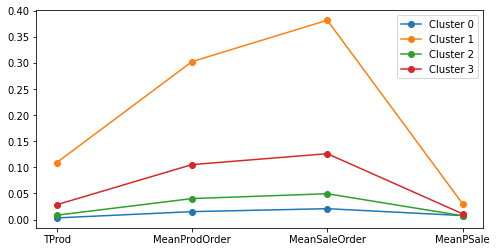

In [9]:
# normalized centers
label_s = 10
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

Text(0.5, 0, 'MeanSaleOrder')

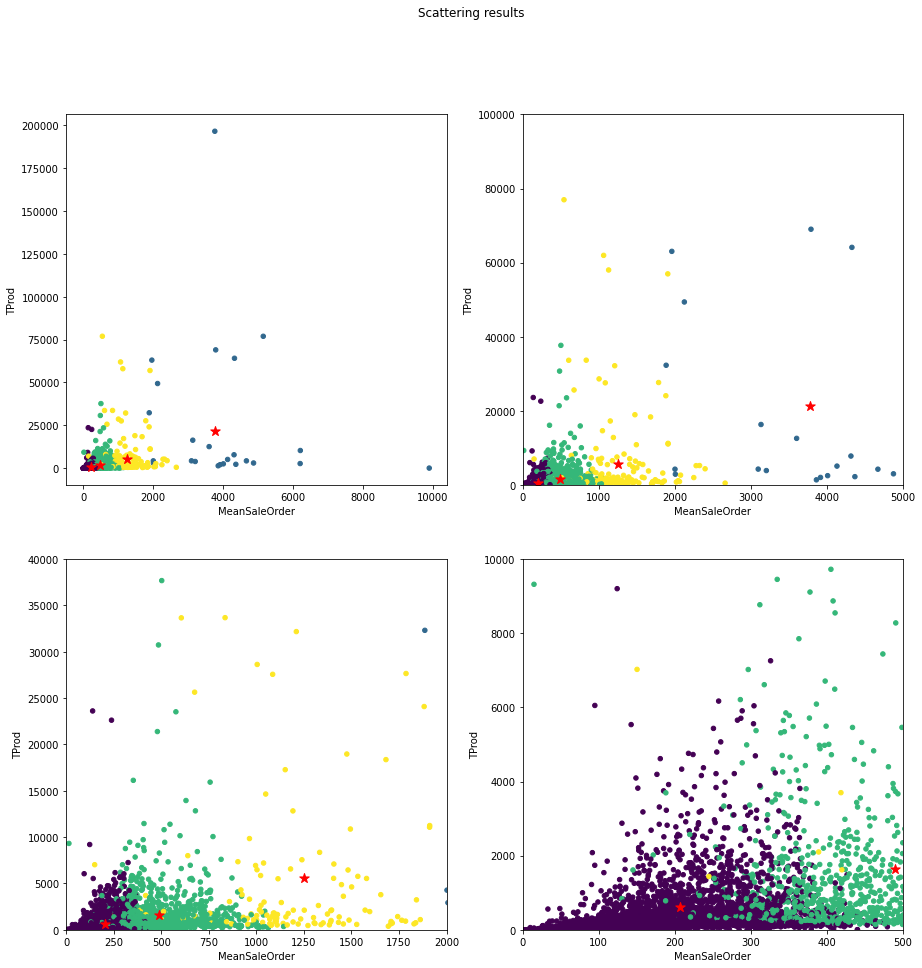

In [10]:
df2 = df_aux
cl = get_clusters(clusters)
center_norm = scaler.inverse_transform(centers)
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Scattering results')
label_s = 10
col1, i1 = df2['MeanSaleOrder'], 2
col2, i2 = df2['TProd'], 0
axs[0][0].scatter(col1, col2, c=cl, s=20)
axs[0][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][0].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[0][0].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[0][1].set_xlim((0,5000))
axs[0][1].set_ylim((0,100000))
axs[0][1].scatter(col1, col2, c=cl, s=20)
axs[0][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][1].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[0][1].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[1][0].set_xlim((0,2000))
axs[1][0].set_ylim((0,40000))
axs[1][0].scatter(col1, col2, c=cl, s=20)
axs[1][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][0].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[1][0].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[1][1].set_xlim((0,500))
axs[1][1].set_ylim((0,10000))
axs[1][1].scatter(col1, col2, c=cl, s=20)
axs[1][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][1].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[1][1].set_xlabel(df2.columns[i1], fontsize=label_s)

In [11]:
l = get_clusters(clusters)
print("Silhouette score: ", silhouette_score(X, l))
print('Davies-Bouldin score: ', davies_bouldin_score(X, l))

Silhouette score:  0.49756186359212995
Davies-Bouldin score:  0.973474224933508


[0:3086] [1:24] [2:1086] [3:137] 

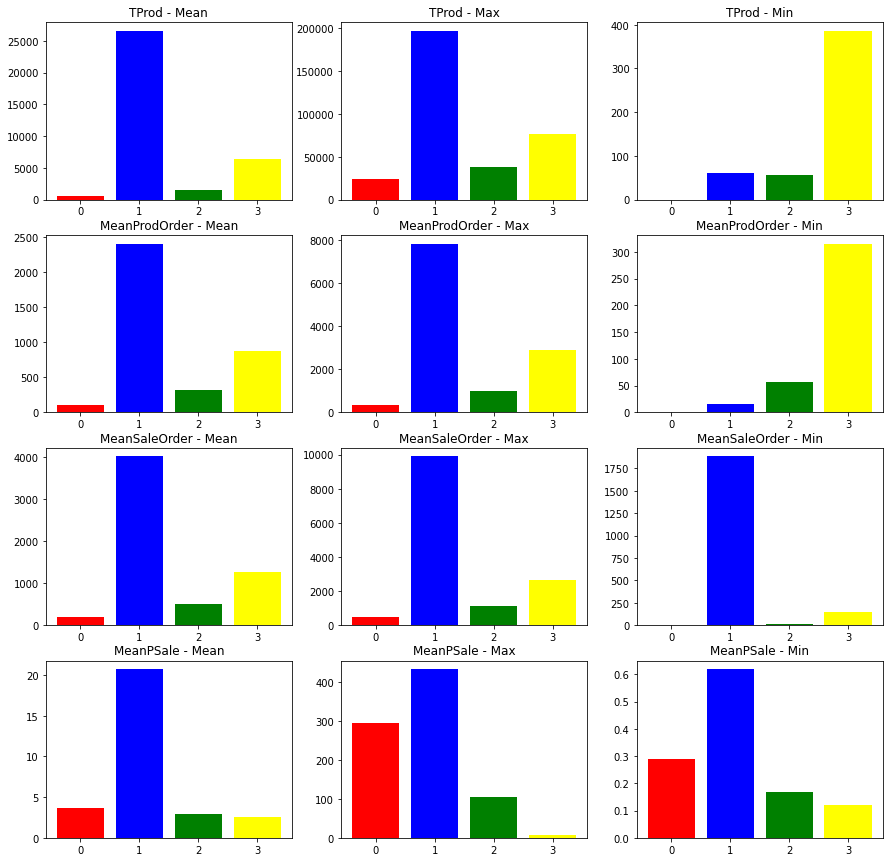

In [12]:
cdf = get_dataframe(df, get_clusters(clusters))
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)

In [13]:
# ---------------------------

# ---------------------------

In [14]:
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

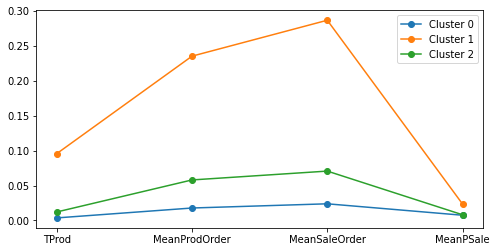

In [15]:
# normalized centers
label_s = 10
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=label_s)
plt.xticks(range(0, len(df_aux.columns)), df_aux.columns, fontsize=label_s)
plt.legend(fontsize=label_s)
plt.show()

Text(0.5, 0, 'MeanSaleOrder')

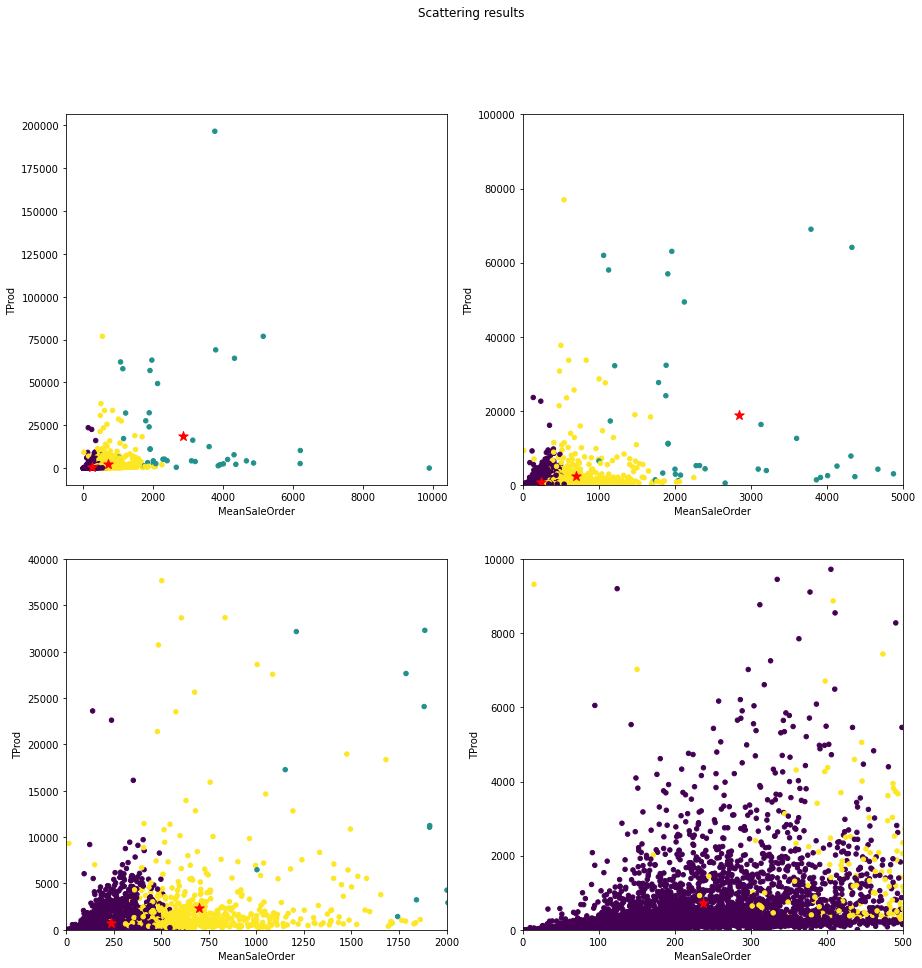

In [16]:
df2 = df_aux
cl = get_clusters(clusters)
center_norm = scaler.inverse_transform(centers)
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Scattering results')
label_s = 10
col1, i1 = df2['MeanSaleOrder'], 2
col2, i2 = df2['TProd'], 0
axs[0][0].scatter(col1, col2, c=cl, s=20)
axs[0][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][0].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[0][0].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[0][1].set_xlim((0,5000))
axs[0][1].set_ylim((0,100000))
axs[0][1].scatter(col1, col2, c=cl, s=20)
axs[0][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[0][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[0][1].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[0][1].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[1][0].set_xlim((0,2000))
axs[1][0].set_ylim((0,40000))
axs[1][0].scatter(col1, col2, c=cl, s=20)
axs[1][0].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][0].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][0].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[1][0].set_xlabel(df2.columns[i1], fontsize=label_s)

axs[1][1].set_xlim((0,500))
axs[1][1].set_ylim((0,10000))
axs[1][1].scatter(col1, col2, c=cl, s=20)
axs[1][1].scatter([c[i1] for c in center_norm], [c[i2] for c in center_norm], s=100, marker='*', c='r')
axs[1][1].tick_params(axis='both', which='major', labelsize=label_s)
axs[1][1].set_ylabel(df2.columns[i2], fontsize=label_s)
axs[1][1].set_xlabel(df2.columns[i1], fontsize=label_s)

In [17]:
skip = list(df.index).index(15098)
X = np.delete(X, [skip], axis=0)
l = get_clusters(clusters, ignore=[skip])
print("Silhouette score: ", silhouette_score(X, l))
print('Davies-Bouldin score: ', davies_bouldin_score(X, l))

Silhouette score:  0.6206755907312664
Davies-Bouldin score:  0.8650914791834757


[0:3681] [1:41] [2:610] 

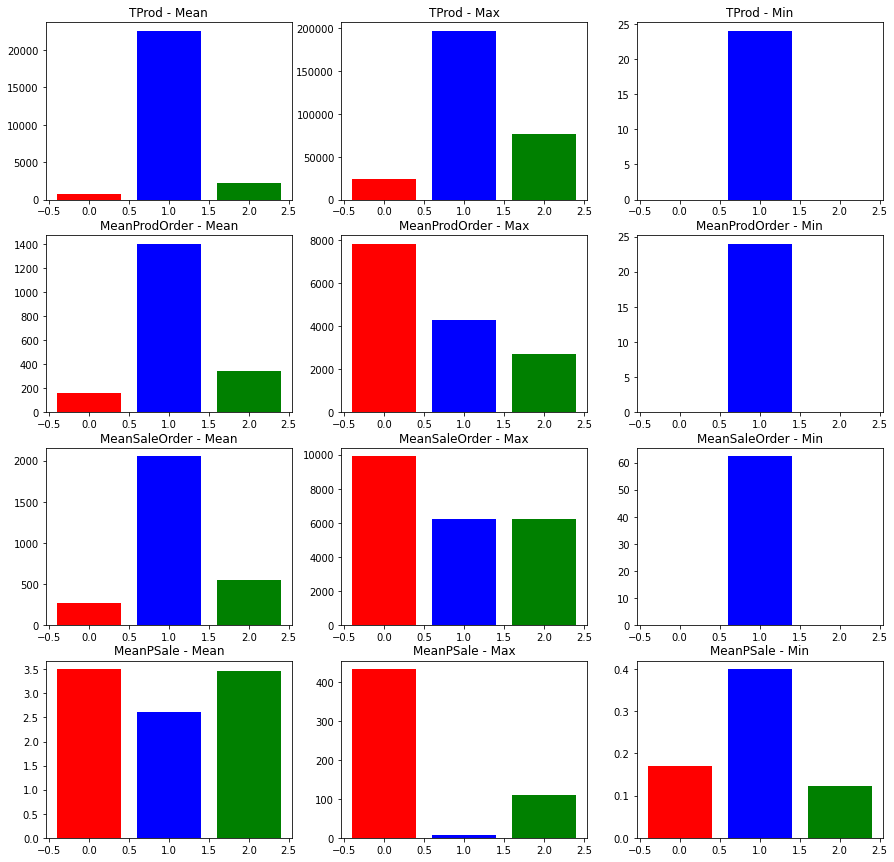

In [18]:
cdf = get_dataframe(df, get_clusters(clusters, ignore=[skip]))
for cluster, cluster_df in cdf.items():
    print(f"[{cluster}:{len(cluster_df)}]", end=" ")
plot_cluster_values(cdf, df_aux)